In [38]:
import torch
from torch import tensor
from torch import optim

In [44]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Requires_grad

In [9]:
a = tensor([2., 3.])
a.requires_grad

False

In [10]:
# define property requires_grad = True to allow backpropagation
a = tensor([2., 3.], requires_grad=True)
a.requires_grad

True

autograd is a spread-out property, that the tensors computed from tensor `a` also have `requires_grad=True`.

In [6]:
b = a**2
c = 2*b
print(b.requires_grad)
print(c.requires_grad)

True
True


A tensor computed from a bunch of tensors that only one of them has `requires_grad = True` also automatically set up to be autograd.

In [11]:
a = tensor([2., 3.], requires_grad=True)
b = tensor([1., 1.])

print(a.requires_grad)
print(b.requires_grad)

c = a + b
print(c.requires_grad)

True
False
True


Once tensors have `requires_grad=True`, Pytorch automatically builts a **computational graph**.

In [29]:
x = tensor([3])
y = tensor([10]) 
a = tensor([1.], requires_grad=True)
b = tensor([2.], requires_grad=True)

y_hat = a*x + b
z = y_hat - y
L = z**2

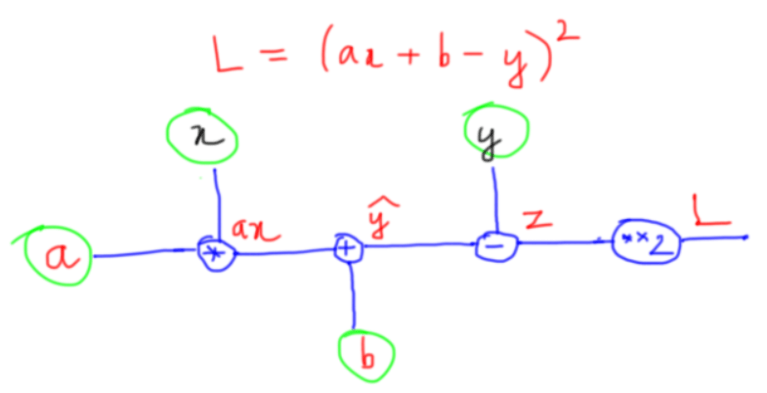

In [23]:
# is_leaf is a property of tensor indicating if a node in computational graph is a leaf or not
print("x is leaf: {}".format(x.is_leaf))
print("w is leaf: {}".format(a.is_leaf))
print("y_hat is leaf: {}".format(y_hat.is_leaf))
print("L is leaf: {}".format(L.is_leaf))

x is leaf: True
w is leaf: True
y_hat is leaf: False
L is leaf: False


Backward
$$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial z} . \frac{\partial z}{\partial \hat{y}} . \frac{\partial \hat{y}}{\partial a} = 2z . 1 . 1 . x = 2zx.$$

In the above example, $x=3, \hat{y}=5, z=-5$ so $\frac{\partial L}{\partial a}=-30.$

As the same, we compute the gradient of $L$ w.r.t. $b$:
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z} . \frac{\partial z}{\partial \hat{y}} . \frac{\partial \hat{y}}{\partial b} = 2z = -10.$$

In [21]:
L.backward()
# Backpropagation computed by Pytorch has the same results
print(a.grad)
print(b.grad)

tensor([-30.])
tensor([-10.])


# Function

In [25]:
print(x.grad_fn)
print(a.grad_fn)
print(y_hat.grad_fn)
print(z.grad_fn)
print(L.grad_fn)

None
None


We can use torchviz library to visualize computational graph in Pytorch.

In [27]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=d63937ef6309bcd76a37774876727d052a0ab935d3e2f9699d06c5067ffbefa1
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


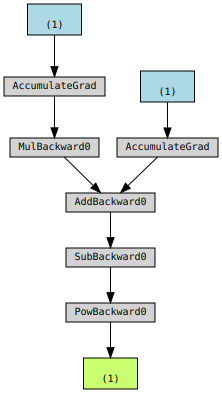

In [30]:
from torchviz import make_dot
make_dot(L)

Class `MulBackward`, `AddBackward`, `SubBackward`, and `PowBackward` are inherited from **`torch.nn.Autograd.Function`**. There are 2 important functions which must noticed when we intend to custom `MyOwnBackward`:


*   `def forward(ctx, input)`
*   `def backward(ctx, grad_output)`



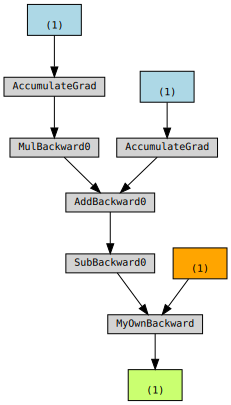

In [33]:
class MyOwn(torch.autograd.Function):

  @staticmethod
  def forward(ctx, input):
    ctx.save_for_backward(input)
    return input**2

  @staticmethod
  def backward(ctx, grad_output):
    input, = ctx.saved_tensors
    return 2*input*grad_output

# alias để gọi hàm
my_backward = MyOwn.apply

# xây lại graph
x = torch.tensor([3])
y = torch.tensor([10])
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([2.], requires_grad=True)

y_hat = a*x + b
z = y_hat - y
L = my_backward(z)
make_dot(L)

We gain the same gradient with our customed `MyOwnBackward`.

In [34]:
L.backward()
print(a.grad)
print(b.grad)

tensor([-30.])
tensor([-10.])


# Backward

In [36]:
x = tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
z = sum(y)
z.backward()

print(x.grad)

tensor([2., 2., 2.])


When we pass a tensor to `gradient` property of `backward` function, Pytorch assumes that it is the backward gradients of the next adjacent layer. 

In [37]:
x = tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
y.backward(gradient=tensor([1, 2, 1]))

print(x.grad)

tensor([2., 4., 2.])


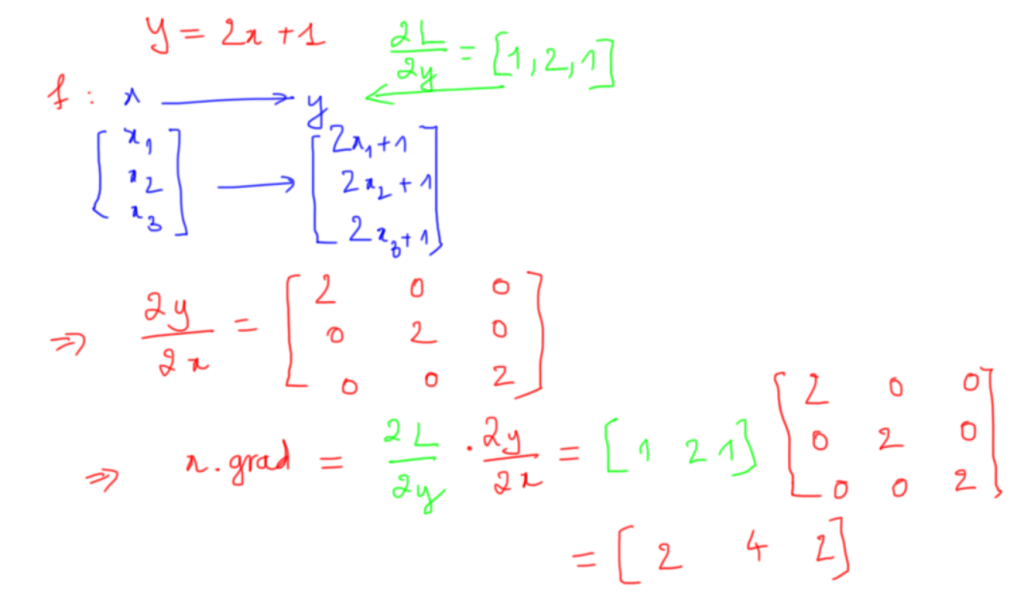

# Dynamic Computational Graph

In [43]:
x = tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
z = sum(y)

for i in range(3):
  z.backward(retain_graph=True)
  print(x.grad)

tensor([2., 2., 2.])
tensor([4., 4., 4.])
tensor([6., 6., 6.])


# Linear Regression

In [78]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# load dataset, convert to numpy 
data = pd.read_csv("/content/drive/MyDrive/Deep Learning AI4E/2. Linear Regression/Homework/data_linear.csv").values

# convert from numpy to torch.tensor
x = tensor(data[:, 0])
y = tensor(data[:, 1])

In [79]:
# define model f(x) = ax + b
def model(x, a, b):
  return a * x + b

In [80]:
# loss function, mean squared error
def loss_fn(y_hat, y):
  squared_diffs = (y_hat - y)**2
  return squared_diffs.mean()

In [83]:
# training function
def training_loop(n_epochs, learning_rate, params, x, y):
  a, b = params
  # save loss to visualize
  losses = []
  for epoch in range(1, n_epochs + 1):
    if a.grad is not None:
      a.grad.zero_()
    if b.grad is not None:
      b.grad.zero_()
    
    # build model
    y_hat = model(x, a, b)
    loss = loss_fn(y_hat, y)

    # call backward
    loss.backward()

    # update a, b by gradient descent
    with torch.no_grad():
      a -= learning_rate * a.grad
      b -= learning_rate * b.grad

    losses.append(loss.item())
    print("Epoch {}: loss = {}".format(epoch, float(loss)))

  return a, b, losses

In [84]:
a = torch.ones((),requires_grad=True)
b = torch.zeros((),requires_grad=True)
a, b, losses = training_loop(30, 0.00005, (a, b), x, y)

Epoch 1: loss = 928658.1763034967
Epoch 2: loss = 264754.35466952855
Epoch 3: loss = 75608.34871753215
Epoch 4: loss = 21720.67590947346
Epoch 5: loss = 6368.099589460872
Epoch 6: loss = 1994.1602331480253
Epoch 7: loss = 748.0231926976953
Epoch 8: loss = 392.999770739465
Epoch 9: loss = 291.8532757802994
Epoch 10: loss = 263.03678855880304
Epoch 11: loss = 254.82663557335485
Epoch 12: loss = 252.48752010810196
Epoch 13: loss = 251.82106667996172
Epoch 14: loss = 251.63112719774702
Epoch 15: loss = 251.57695432273485
Epoch 16: loss = 251.56145705779767
Epoch 17: loss = 251.55697741368428
Epoch 18: loss = 251.55563733354356
Epoch 19: loss = 251.55518874602416
Epoch 20: loss = 251.5549954601149
Epoch 21: loss = 251.55487445831062
Epoch 22: loss = 251.55477384208717
Epoch 23: loss = 251.55467903433876
Epoch 24: loss = 251.55458592332786
Epoch 25: loss = 251.55449331649933
Epoch 26: loss = 251.55440086558835
Epoch 27: loss = 251.55430845484324
Epoch 28: loss = 251.55421605355247
Epoch 29: 

Text(0, 0.5, 'loss')

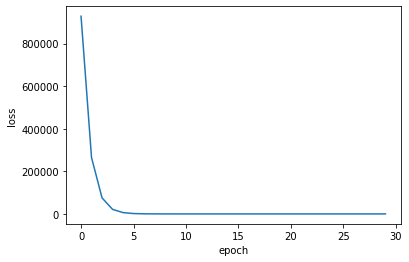

In [65]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

In [66]:
# predict x = 50
x = torch.tensor(50)
with torch.no_grad():
    y_hat = model(x, a, b)
    print(y_hat)

tensor(755.6882)


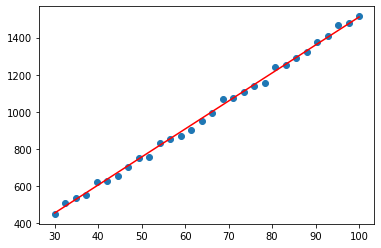

In [67]:
with torch.no_grad():
    y_hat = model(x, a, b)
plt.scatter(x, y)
plt.plot(x, y_hat, c='r')